In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#text processing
import re
import string
import nltk
from gensim import corpora, models, similarities 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#LDA
import gensim
import pyLDAvis.gensim_models

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#read the csv file with scraped data
news_data=pd.read_csv('news_output.csv',error_bad_lines=False)
news_data['Title'] = news_data['Title'].astype(str)
news_data['Text'] = news_data['Text'].astype(str)
news_data.head()

,siteName,Title,Authors,Text,Link,Published_Date
0,nytimes,Americans Plead Guilty in Japan to Aiding Carl...,['Ben Dooley'],TOKYO — An American father and son pleaded gui...,https://www.nytimes.com/2021/06/14/business/ta...,2021-06-14 00:00:00
1,nytimes,England’s plan to reopen on June 21 could be d...,['Stephen Castle'],"Andrew Lloyd Webber, the producer of musicals ...",https://www.nytimes.com/2021/06/14/world/uk-lo...,2021-06-14 00:00:00
2,nytimes,Hollywood Take on Christchurch Massacre Provok...,['Natasha Frost'],"AUCKLAND, New Zealand — A planned Hollywood fi...",https://www.nytimes.com/2021/06/14/world/asia/...,2021-06-14 00:00:00
3,nytimes,Netanyahu Ousted as Israeli Parliament Votes i...,"['Patrick Kingsley', 'Richard Pérez-Peña']","But amid the acrimony, there were also moments...",https://www.nytimes.com/2021/06/13/world/middl...,2021-06-13 00:00:00
4,nytimes,Why the Mexico City Metro Collapsed,"['Natalie Kitroeff', 'Maria Abi-Habib', 'James...",Why the Mexico City Metro Collapsed A Times in...,https://www.nytimes.com/interactive/2021/06/12...,2021-06-12 00:00:00


In [3]:
def initial_clean(text):
    """
    Function to clean text-remove punctuations, lowercase text etc.
    
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
stop_words.extend(['news', 'say','use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do','took','time','year',
                   'done', 'try', 'many', 'some','nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 
                   'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line','even', 'also', 'may', 'take', 'come', 'new','said', 'like','people'])
def remove_stop_words(text):
    """
    Function to remove all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text


In [4]:
def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

## LDA on news articles

In [5]:
#combining text and title into a single column
news_data["title_text"] = news_data["Title"] + news_data["Text"]

# clean text and title and create new column "tokenized"
import time
t1 = time.time()
#news_data['tokenized_title'] = news_data['Title'].apply(apply_all) 
news_data['tokenized_title_text'] = news_data['title_text'].apply(apply_all) 
t2 = time.time()
print("Time to clean and tokenize", len(news_data), "articles:", (t2-t1)/60, "min")


Time to clean and tokenize 349 articles: 0.12033392190933227 min


In [6]:
##create a Gensim dictionary from the tokenized data
combined = news_data['tokenized_title_text']
dictionary = corpora.Dictionary(combined)
#removing extremes 
dictionary.filter_extremes(no_below=1, no_above=0.8)
#convert the dictionary to a bag of words corpus 
corpus_combined = [dictionary.doc2bow(combine) for combine in combined]


In [7]:
#LDA
ldamodel_combined = gensim.models.ldamodel.LdaModel(corpus_combined, num_topics = 7, id2word=dictionary, passes=15)
ldamodel_combined.save('model_combined.gensim')
topics = ldamodel_combined.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.016*"inform" + 0.012*"servic" + 0.006*"provid" + 0.005*"us"')
(1, '0.006*"vaccin" + 0.005*"us" + 0.004*"june" + 0.004*"one"')
(2, '0.049*"de" + 0.034*"la" + 0.022*"que" + 0.019*"el"')
(3, '0.006*"one" + 0.004*"us" + 0.004*"work" + 0.004*"show"')
(4, '0.005*"countri" + 0.005*"netanyahu" + 0.005*"govern" + 0.004*"us"')
(5, '0.016*"hurrican" + 0.009*"dorian" + 0.009*"photo" + 0.009*"storm"')
(6, '0.004*"tax" + 0.004*"one" + 0.004*"vaccin" + 0.004*"us"')


In [16]:
#visualizing topics
lda_viz_combined = gensim.models.ldamodel.LdaModel.load('model_combined.gensim')
lda_display_combined = pyLDAvis.gensim_models.prepare(lda_viz_combined, corpus_combined, dictionary, sort_topics=True)
pyLDAvis.display(lda_display_combined)


### Dominant Topic in each article

In [9]:
def dominant_topic(ldamodel, corpus, texts):
    # Function to find the dominant topic in each article
    sent_topics_df = pd.DataFrame()

    # Get main topic in each article
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each article
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=4)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [10]:
df_dominant_topic = dominant_topic(ldamodel=ldamodel_combined, corpus=corpus_combined, texts=news_data['title_text'])
df_dominant_topic['Title'] = news_data['Title']
df_dominant_topic['Link'] = news_data['Link']
df_dominant_topic.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,title_text,Title,Link
0,3.0,0.9921,"one, us, work, show",Americans Plead Guilty in Japan to Aiding Carl...,Americans Plead Guilty in Japan to Aiding Carl...,https://www.nytimes.com/2021/06/14/business/ta...
1,4.0,0.9928,"countri, netanyahu, govern, us",England’s plan to reopen on June 21 could be d...,England’s plan to reopen on June 21 could be d...,https://www.nytimes.com/2021/06/14/world/uk-lo...
2,3.0,0.9909,"one, us, work, show",Hollywood Take on Christchurch Massacre Provok...,Hollywood Take on Christchurch Massacre Provok...,https://www.nytimes.com/2021/06/14/world/asia/...
3,4.0,0.9970,"countri, netanyahu, govern, us",Netanyahu Ousted as Israeli Parliament Votes i...,Netanyahu Ousted as Israeli Parliament Votes i...,https://www.nytimes.com/2021/06/13/world/middl...
4,4.0,0.9996,"countri, netanyahu, govern, us",Why the Mexico City Metro CollapsedWhy the Mex...,Why the Mexico City Metro Collapsed,https://www.nytimes.com/interactive/2021/06/12...


## Plot of article distribution by dominant topic

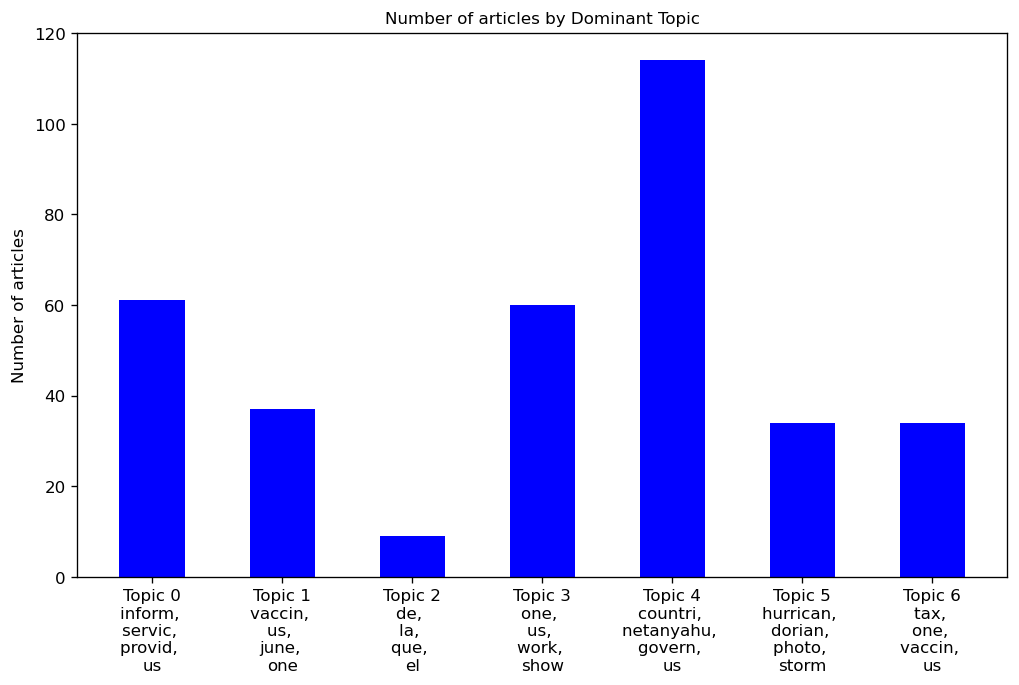

In [11]:
#topic group
topic_group = df_dominant_topic.groupby('Dominant_Topic').size()
topic_group = topic_group.to_frame(name='count').reset_index()
topic_group

# Top 4 Keywords for each Topic
topic_top4words = [(i, topic) for i, topics in ldamodel_combined.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 4]
df_top4words_stacked = pd.DataFrame(topic_top4words, columns=['topic_id', 'words'])
df_top4words = df_top4words_stacked.groupby('topic_id').agg(', \n'.join)
df_top4words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1) = plt.subplots(figsize=(10, 6), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=topic_group, width=.5, color='b')
ax1.set_xticks(range(topic_group.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top4words.loc[df_top4words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of articles by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of articles')
ax1.set_ylim(0, 120)
plt.show()


## Grouping articles by title 

In [12]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
topic_groups = df_dominant_topic.groupby('Dominant_Topic')
#Enter the topic number of your choice
topic_groups.get_group(0).sort_values(by=['Perc_Contribution'], ascending=False).head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,title_text,Title,Link
298,0,0.9997,"inform, servic, provid, us",Accident or homicide? Debate lingers over caus...,Accident or homicide? Debate lingers over caus...,https://www.cbsnews.com/news/cayley-mandadi-de...
132,0,0.9996,"inform, servic, provid, us","Privacy PolicyPublished: March 23, 2021\r\n\r\...",Privacy Policy,https://www.washingtonpost.com/privacy-policy/...
131,0,0.9996,"inform, servic, provid, us","Privacy PolicyPublished: March 23, 2021\r\n\r\...",Privacy Policy,https://www.washingtonpost.com/privacy-policy/...
130,0,0.9994,"inform, servic, provid, us","Terms of ServicePublished: July 1, 2014.\r\n\r...",Terms of Service,https://www.washingtonpost.com/terms-of-servic...
172,0,0.9991,"inform, servic, provid, us",Why are women more prone to long Covid?In June...,Why are women more prone to long Covid?,https://www.theguardian.com/society/2021/jun/1...


## Top 10 similar article

In [13]:
def get_similar(query):
    vectorizer = TfidfVectorizer(stop_words='english',
                     binary=False,
                     max_df=0.95, 
                     min_df=0.15,
                     ngram_range = (1,2),use_idf = False, norm = None)
    doc_vectors = vectorizer.fit_transform(news_data['title_text'])
    results=[]
    q_vector = vectorizer.transform([query])
    print("Query: ", query)
    results.append(cosine_similarity(q_vector, doc_vectors.toarray()))
    #f=0
    elem_list=[]
    for i in results[:10]:
        for elem in i[0]:
            elem_list.append(elem)
            #f+=1
            sim_index = np.argsort(elem_list)[-10:]
    similarity = sorted(elem_list,reverse=True)[0:10]
    similar_data = news_data.iloc[sim_index,:]
    similar_data = similar_data.reset_index(drop=True)
    similarity = pd.DataFrame(similarity, columns=['similarity'])
    merged = similarity.merge(similar_data, how='outer', left_index=True, right_index=True)
    merged = merged.replace(r'\\n',' ', regex=True) 
    if sum(elem_list) / len(elem_list)==0.0:
            print("No similar descriptions")
    else:
         print(merged[['similarity','Title']])

In [14]:
similarity = get_similar(" Joe Biden")

Query:   Joe Biden
   similarity                                              Title
0    1.000000  Liz Peek: Biden, G-7 flunk China test – Hold B...
1    1.000000  Some US allies near Russia are wary of Biden-P...
2    1.000000  Biden set for confrontation with Putin over cy...
3    1.000000  Secretary Blinken: Biden to 'begin to test' re...
4    1.000000  Nigel Farage 'worried' about Biden, Boris John...
5    1.000000  Reporter's Notebook: What to expect at G-7 sum...
6    1.000000  Biden Admin heading toward major strategic pol...
7    1.000000  Immigration surge driven by 'crazy Biden polic...
8    0.904534  Pompeo: What is Biden doing to stop China's Xi...
9    0.840673  Nigel Farage 'worried' about Biden, Boris John...
